## 목표
- 비행기 탑승객 데이터를 활용하여 만족여부를 판단하는 모델을 만들어보자: 클래스 몇 개?
- 여러 분류 모델들 중 성능이 가장 좋은 모델을 찾아보자: 모델변경, 모델 하리퍼 파라미터 튜닝(+그리드서치)
- 특성 데이터 전처리를 진행하자: 이상치 처리, 결측치 처리, 득성 추출, 문자->숫자(인코딩)
- 고객 만족도 정보를 분석하여 만족도 품질을 개선하기 위한 방법을 고민해보자!

## 필요한 도구 불러오기

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score # k-fold 교차 검증 - 해당 모델이 일반화된(좋은) 모델인가?
from sklearn.metrics import accuracy_score # 정확도 지표

In [57]:
data = pd.read_csv('./data/airline_passenger_satisfaction.csv')
data_info = pd.read_csv('./data/data_dictionary.csv')

data.head(3)

# pandas옵션 설정 변경해서 컬럼 개수 최대화  -> 생략된 컬럼(메모리 때문에) 다 보고싶다
# Noe: 표현되는 최대 컬럼 개수에 제한이 없음(모두 다 출력)
pd.set_option('display.max_columns',None)
data.head(3)

,ID,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,1,Male,48,First-time,Business,Business,821,2,5.0,3,3,4,3,3,3,5,2,5,5,5,3,5,5,Neutral or Dissatisfied
1,2,Female,35,Returning,Business,Business,821,26,39.0,2,2,3,5,2,5,4,5,5,3,5,2,5,5,Satisfied
2,3,Male,41,Returning,Business,Business,853,0,0.0,4,4,4,5,4,3,5,3,5,5,3,4,3,3,Satisfied


In [58]:
# data_info : 딕셔너리 컬럼 정보
data_info

,Field,Description
0,ID,Unique passenger identifier
1,Gender,Gender of the passenger (Female/Male)
2,Age,Age of the passenger
3,Customer Type,Type of airline customer (First-time/Returning)
4,Type of Travel,Purpose of the flight (Business/Personal)
5,Class,Travel class in the airplane for the passenger...
6,Flight Distance,Flight distance in miles
7,Departure Delay,Flight departure delay in minutes
8,Arrival Delay,Flight arrival delay in minutes
9,Departure and Arrival Time Convenience,Satisfaction level with the convenience of the...


| 열 이름 | 설명 |
|---------|------|
| ID | 승객의 고유 식별자 |
| Gender | 승객의 성별 (여성/남성) |
| Age | 승객의 나이 |
| Customer Type | 항공사 고객 유형 (첫 이용/재방문) |
| Type of Travel | 비행 목적 (비즈니스/개인) |
| Class | 비행기 좌석 등급 |
| Flight Distance | 비행 거리 (마일 단위) |
| Departure Delay | 출발 지연 시간 (분 단위) |
| Arrival Delay | 도착 지연 시간 (분 단위) |
| Departure and Arrival Time Convenience | 항공편 출발 및 도착 시간 편리성 만족도 (1~5, 0=해당 없음) |
| Ease of Online Booking | 온라인 예약 경험 만족도 (1~5, 0=해당 없음) |
| Check-in Service | 체크인 서비스 만족도 (1~5, 0=해당 없음) |
| Online Boarding | 온라인 탑승 절차 만족도 (1~5, 0=해당 없음) |
| Gate Location | 공항 내 게이트 위치 만족도 (1~5, 0=해당 없음) |
| On-board Service | 기내 탑승 서비스 만족도 (1~5, 0=해당 없음) |
| Seat Comfort | 좌석 편안함 만족도 (1~5, 0=해당 없음) |
| Leg Room Service | 다리 공간 서비스 만족도 (1~5, 0=해당 없음) |
| Cleanliness | 기내 청결 만족도 (1~5, 0=해당 없음) |
| Food and Drink | 기내 음식 및 음료 만족도 (1~5, 0=해당 없음) |
| In-flight Service | 기내 서비스 만족도 (1~5, 0=해당 없음) |
| In-flight Wifi Service | 기내 와이파이 서비스 만족도 (1~5, 0=해당 없음) |
| In-flight Entertainment | 기내 엔터테인먼트 만족도 (1~5, 0=해당 없음) |
| Baggage Handling | 수하물 처리 만족도 (1~5, 0=해당 없음) |
| Satisfaction | 항공사에 대한 전반적인 만족도 (만족/보통 또는 불만족) |

In [60]:
# data 전체 정보
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   ID                                      129880 non-null  int64  
 1   Gender                                  129880 non-null  object 
 2   Age                                     129880 non-null  int64  
 3   Customer Type                           129880 non-null  object 
 4   Type of Travel                          129880 non-null  object 
 5   Class                                   129880 non-null  object 
 6   Flight Distance                         129880 non-null  int64  
 7   Departure Delay                         129880 non-null  int64  
 8   Arrival Delay                           129487 non-null  float64
 9   Departure and Arrival Time Convenience  129880 non-null  int64  
 10  Ease of Online Booking                  1298

In [61]:
data.isnull().sum()

ID                                          0
Gender                                      0
Age                                         0
Customer Type                               0
Type of Travel                              0
Class                                       0
Flight Distance                             0
Departure Delay                             0
Arrival Delay                             393
Departure and Arrival Time Convenience      0
Ease of Online Booking                      0
Check-in Service                            0
Online Boarding                             0
Gate Location                               0
On-board Service                            0
Seat Comfort                                0
Leg Room Service                            0
Cleanliness                                 0
Food and Drink                              0
In-flight Service                           0
In-flight Wifi Service                      0
In-flight Entertainment           

- 결측치 : Arrival Delay                             393
- 결측 채우거나 제거
  - 채우는 방법: 평균, 최빈값, 최댓값, 다른 특성과의 관계를 살펴보고 연관지어서 채우기
  - 제거: 데이터 행개수 당상히 많은 상황 -> 모델이 학습하는 양에 크게 영향을 주지 않음 -> 제거
<br><br>
- 데이터 타입: int, float, object 다양함
- *머신러닝 학습 가능한 데이터 유형: object는 이해할 수 없고, 수치형태의 데이터만 학습 가능
  - object(문자열) -> 숫자형(수치형태) : encoding(인코딩) 전처리가 필요함!

### 데이터 전처리(preprocessing)
- 결측치(missing values, Nan, Null) 다뤄보기

In [64]:
# 결측치 있다면 해당 행을 모두 삭제!
data.dropna(inplace=True)
data.isnull().sum()

ID                                        0
Gender                                    0
Age                                       0
Customer Type                             0
Type of Travel                            0
Class                                     0
Flight Distance                           0
Departure Delay                           0
Arrival Delay                             0
Departure and Arrival Time Convenience    0
Ease of Online Booking                    0
Check-in Service                          0
Online Boarding                           0
Gate Location                             0
On-board Service                          0
Seat Comfort                              0
Leg Room Service                          0
Cleanliness                               0
Food and Drink                            0
In-flight Service                         0
In-flight Wifi Service                    0
In-flight Entertainment                   0
Baggage Handling                

- 인코딩 진행해야하는 상황
- 데이터 탐색을 위해서 인코딩은 뒤로 미루자!

### 데이터 탐색
- 고객 감성을 분석해보자(개인)
  - 불만족(+보통) 또는 만족하는 고객의 특징을 살펴보자
  - 고객 만족도 개선 방향 정리해보자
- 전처리를 위한 범주데이터 확인 -> 인코딩 진행

In [67]:
data.head()

,ID,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,1,Male,48,First-time,Business,Business,821,2,5.0,3,3,4,3,3,3,5,2,5,5,5,3,5,5,Neutral or Dissatisfied
1,2,Female,35,Returning,Business,Business,821,26,39.0,2,2,3,5,2,5,4,5,5,3,5,2,5,5,Satisfied
2,3,Male,41,Returning,Business,Business,853,0,0.0,4,4,4,5,4,3,5,3,5,5,3,4,3,3,Satisfied
3,4,Male,50,Returning,Business,Business,1905,0,0.0,2,2,3,4,2,5,5,5,4,4,5,2,5,5,Satisfied
4,5,Female,49,Returning,Business,Business,3470,0,1.0,3,3,3,5,3,3,4,4,5,4,3,3,3,3,Satisfied


In [68]:
dissat_df = data[data['Satisfaction']=='Neutral or Dissatisfied']
dissat_df

,ID,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,1,Male,48,First-time,Business,Business,821,2,5.0,3,3,4,3,3,3,5,2,5,5,5,3,5,5,Neutral or Dissatisfied
8,9,Male,50,Returning,Business,Business,2607,0,0.0,1,1,3,2,1,4,3,4,3,3,4,4,4,4,Neutral or Dissatisfied
10,11,Female,28,First-time,Business,Business,821,0,5.0,1,1,3,1,3,2,2,5,2,2,4,1,2,3,Neutral or Dissatisfied
11,12,Female,27,First-time,Business,Business,421,20,21.0,2,2,1,2,4,2,2,5,1,1,3,1,1,4,Neutral or Dissatisfied
12,13,Male,24,First-time,Business,Economy,453,16,30.0,2,2,2,2,4,2,5,4,5,5,4,2,5,4,Neutral or Dissatisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129874,129875,Female,55,Returning,Personal,Economy Plus,308,0,0.0,4,3,4,4,4,4,3,3,4,2,4,3,4,4,Neutral or Dissatisfied
129875,129876,Male,28,Returning,Personal,Economy Plus,447,2,3.0,4,4,4,4,2,5,1,4,4,4,5,4,4,4,Neutral or Dissatisfied
129876,129877,Male,41,Returning,Personal,Economy Plus,308,0,0.0,5,3,5,3,4,5,2,5,2,2,4,3,2,5,Neutral or Dissatisfied
129877,129878,Male,42,Returning,Personal,Economy Plus,337,6,14.0,5,2,4,2,1,3,3,4,3,3,4,2,3,5,Neutral or Dissatisfied


In [69]:
len(dissat_df)

73225

In [70]:
dissat_df[['Age','Departure Delay','Arrival Delay']].describe()

,Age,Departure Delay,Arrival Delay
count,73225.000000,73225.000000,73225.000000
mean,37.653069,16.340184,17.055992
std,16.464654,40.048343,40.522021
min,7.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000
75%,50.000000,15.000000,16.000000
max,85.000000,1592.000000,1584.000000


In [71]:
sat_df = data[data['Satisfaction']=='Satisfied']
sat_df[['Age','Departure Delay','Arrival Delay']].describe()

,Age,Departure Delay,Arrival Delay
count,56262.000000,56262.000000,56262.000000
mean,41.739824,12.435001,12.533859
std,12.795733,34.865422,35.449502
min,7.000000,0.000000,0.000000
25%,32.000000,0.000000,0.000000
50%,43.000000,0.000000,0.000000
75%,51.000000,9.000000,8.000000
max,85.000000,1305.000000,1280.000000


#### 불만족, 만족 승객 나이 특성, 지연 시간
- 만족도는 불만족에서 평균 37살, 만족에서 평균 41살
- 나이에서 Q1을 보면 불만족은 25, 만족은 32살로 나이가 많은 사람이 서비스 만족하는 경향이 있음을 알 수 있다.
<br><br>
- 출발과 도착 지연시간은 불만족이 만족보다 약 4-5분 길었다.

In [73]:
dissat_df.head(1)

,ID,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,1,Male,48,First-time,Business,Business,821,2,5.0,3,3,4,3,3,3,5,2,5,5,5,3,5,5,Neutral or Dissatisfied


In [74]:
dissat_df.iloc[:,9:-1].mean().sort_values()

In-flight Wifi Service                    2.398470
Ease of Online Booking                    2.549512
Online Boarding                           2.658846
In-flight Entertainment                   2.892236
Cleanliness                               2.932851
Food and Drink                            2.958525
Gate Location                             2.980184
Leg Room Service                          2.990495
On-board Service                          3.019570
Seat Comfort                              3.038525
Check-in Service                          3.043045
Departure and Arrival Time Convenience    3.130229
Baggage Handling                          3.374681
In-flight Service                         3.389662
dtype: float64

#### 불만족 고객의 감성 인사이트
- Wifi 서비스 없는걸 싫어함
- 예약이 수고스러운 것을 싫어함
- 탑승 절차 복잡한 것을 싫어함

In [76]:
sat_df.iloc[:,9:-1].mean().sort_values(ascending=False)

Online Boarding                           4.025648
In-flight Service                         3.971277
Baggage Handling                          3.966638
Seat Comfort                              3.966176
In-flight Entertainment                   3.964345
On-board Service                          3.856475
Leg Room Service                          3.820376
Cleanliness                               3.746134
Check-in Service                          3.648786
Food and Drink                            3.525061
In-flight Wifi Service                    3.158135
Ease of Online Booking                    3.026554
Gate Location                             2.972646
Departure and Arrival Time Convenience    2.962497
dtype: float64

#### 만족 고객의 감성 인사이트
- 탑승 절차 간편 선호
- 기내 서비스 신경씀
- 수하물 처리에 신경씀

In [78]:
differ = sat_df.iloc[:,9:-1].mean() - dissat_df.iloc[:,9:-1].mean()
differ

Departure and Arrival Time Convenience   -0.167732
Ease of Online Booking                    0.477043
Check-in Service                          0.605741
Online Boarding                           1.366802
Gate Location                            -0.007539
On-board Service                          0.836905
Seat Comfort                              0.927651
Leg Room Service                          0.829881
Cleanliness                               0.813283
Food and Drink                            0.566536
In-flight Service                         0.581615
In-flight Wifi Service                    0.759665
In-flight Entertainment                   1.072109
Baggage Handling                          0.591957
dtype: float64

| 열 이름 | 설명 |
|---------|------|
| Departure and Arrival Time Convenience | 항공편 출발 및 도착 시간 편리성 만족도 (1~5, 0=해당 없음) |
| Ease of Online Booking | 온라인 예약 경험 만족도 (1~5, 0=해당 없음) |
| Check-in Service | 체크인 서비스 만족도 (1~5, 0=해당 없음) |
| Online Boarding | 온라인 탑승 절차 만족도 (1~5, 0=해당 없음) |
| Gate Location | 공항 내 게이트 위치 만족도 (1~5, 0=해당 없음) |
| On-board Service | 기내 탑승 서비스 만족도 (1~5, 0=해당 없음) |
| Seat Comfort | 좌석 편안함 만족도 (1~5, 0=해당 없음) |
| Leg Room Service | 다리 공간 서비스 만족도 (1~5, 0=해당 없음) |
| Cleanliness | 기내 청결 만족도 (1~5, 0=해당 없음) |
| Food and Drink | 기내 음식 및 음료 만족도 (1~5, 0=해당 없음) |
| In-flight Service | 기내 서비스 만족도 (1~5, 0=해당 없음) |
| In-flight Wifi Service | 기내 와이파이 서비스 만족도 (1~5, 0=해당 없음) |
| In-flight Entertainment | 기내 엔터테인먼트 만족도 (1~5, 0=해당 없음) |
| Baggage Handling | 수하물 처리 만족도 (1~5, 0=해당 없음) |


In [80]:
# 만족과 불만족의 평점 차이가 컷던 항목들
# On-board Service                          0.836905 기내 탑승 서비스 만족도 
# Seat Comfort                              0.927651 좌석 편안함 만족도
# Leg Room Service                          0.829881 다리 공간 서비스 만족도
# Cleanliness                               0.813283 기내 청결 만족도

#### 승객 만족도 향상을 위해
- 좌석 편안함을 높이고, 다리 공간, 탑승 서비스, 기내 청결도를 향상하면 전반적인 승객 만족도가 향상될 것이라 예상됨

### 데이터 전처리
- 문자열 데이터 타입 컬럼 찾아보기

In [83]:
# X, y분리
X = data.drop('Satisfaction',axis=1)
y = data['Satisfaction']
X.shape, y.shape

((129487, 23), (129487,))

In [84]:
# 판다스 1차원 자료 - Series
ob_feature = []
# 많은 컬럼 중 object 타입을 가진 컬럼명에 접근!
data.dtypes[data.dtypes=='object'][:-1]

Gender            object
Customer Type     object
Type of Travel    object
Class             object
dtype: object

In [85]:
ob_feature = data.dtypes[data.dtypes=='object'][:-1].index
ob_feature

Index(['Gender', 'Customer Type', 'Type of Travel', 'Class'], dtype='object')

In [86]:
data[ob_feature]

,Gender,Customer Type,Type of Travel,Class
0,Male,First-time,Business,Business
1,Female,Returning,Business,Business
2,Male,Returning,Business,Business
3,Male,Returning,Business,Business
4,Female,Returning,Business,Business
...,...,...,...,...
129875,Male,Returning,Personal,Economy Plus
129876,Male,Returning,Personal,Economy Plus
129877,Male,Returning,Personal,Economy Plus
129878,Male,Returning,Personal,Economy Plus


In [87]:
# 또다른 방법
data.select_dtypes(include='object').iloc[:,:-1]

,Gender,Customer Type,Type of Travel,Class
0,Male,First-time,Business,Business
1,Female,Returning,Business,Business
2,Male,Returning,Business,Business
3,Male,Returning,Business,Business
4,Female,Returning,Business,Business
...,...,...,...,...
129875,Male,Returning,Personal,Economy Plus
129876,Male,Returning,Personal,Economy Plus
129877,Male,Returning,Personal,Economy Plus
129878,Male,Returning,Personal,Economy Plus


In [88]:
X[ob_feature]

,Gender,Customer Type,Type of Travel,Class
0,Male,First-time,Business,Business
1,Female,Returning,Business,Business
2,Male,Returning,Business,Business
3,Male,Returning,Business,Business
4,Female,Returning,Business,Business
...,...,...,...,...
129875,Male,Returning,Personal,Economy Plus
129876,Male,Returning,Personal,Economy Plus
129877,Male,Returning,Personal,Economy Plus
129878,Male,Returning,Personal,Economy Plus


- 인코딩 방식
  - 1) 레이블 인코딩: 카테고리 하나당 숫자를 mapping(연결)
    2) 원핫인코딩: 0,1 수치형태로 표현하는 인코딩 기법+ 카테고리만큼 컬럼 생성

In [90]:
# 원핫인코딩 해보기
# 여러개 컬럼을 한꺼번에 인코딩할 경우 접두사(pre_fix)가 연결되어서, 기존 컬럼명도 표현해줌
# pd.get_dummies(X[['Gender', 'Class']],dtype='int32')
dummie = pd.get_dummies(X[ob_feature],dtype='int8')
dummie

,Gender_Female,Gender_Male,Customer Type_First-time,Customer Type_Returning,Type of Travel_Business,Type of Travel_Personal,Class_Business,Class_Economy,Class_Economy Plus
0,0,1,1,0,1,0,1,0,0
1,1,0,0,1,1,0,1,0,0
2,0,1,0,1,1,0,1,0,0
3,0,1,0,1,1,0,1,0,0
4,1,0,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
129875,0,1,0,1,0,1,0,0,1
129876,0,1,0,1,0,1,0,0,1
129877,0,1,0,1,0,1,0,0,1
129878,0,1,0,1,0,1,0,0,1


In [91]:
dummie.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129487 entries, 0 to 129879
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   Gender_Female             129487 non-null  int8 
 1   Gender_Male               129487 non-null  int8 
 2   Customer Type_First-time  129487 non-null  int8 
 3   Customer Type_Returning   129487 non-null  int8 
 4   Type of Travel_Business   129487 non-null  int8 
 5   Type of Travel_Personal   129487 non-null  int8 
 6   Class_Business            129487 non-null  int8 
 7   Class_Economy             129487 non-null  int8 
 8   Class_Economy Plus        129487 non-null  int8 
dtypes: int8(9)
memory usage: 2.1 MB


In [92]:
# 기존 데이터와 원핫 인코딩된 데이터 병합(열방향)
# 원핫인코딩 이전의 컬럼은 제거
# concat: 기본적으로 행방향으로 결합, 열방향(axis=1) 결합으로 변경하여 사용하자
# merge: 특정 열을 기준으로 병합을 하는 함수
X = pd.concat([X, dummie], axis=1)
X

,ID,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Gender_Female,Gender_Male,Customer Type_First-time,Customer Type_Returning,Type of Travel_Business,Type of Travel_Personal,Class_Business,Class_Economy,Class_Economy Plus
0,1,Male,48,First-time,Business,Business,821,2,5.0,3,3,4,3,3,3,5,2,5,5,5,3,5,5,0,1,1,0,1,0,1,0,0
1,2,Female,35,Returning,Business,Business,821,26,39.0,2,2,3,5,2,5,4,5,5,3,5,2,5,5,1,0,0,1,1,0,1,0,0
2,3,Male,41,Returning,Business,Business,853,0,0.0,4,4,4,5,4,3,5,3,5,5,3,4,3,3,0,1,0,1,1,0,1,0,0
3,4,Male,50,Returning,Business,Business,1905,0,0.0,2,2,3,4,2,5,5,5,4,4,5,2,5,5,0,1,0,1,1,0,1,0,0
4,5,Female,49,Returning,Business,Business,3470,0,1.0,3,3,3,5,3,3,4,4,5,4,3,3,3,3,1,0,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,129876,Male,28,Returning,Personal,Economy Plus,447,2,3.0,4,4,4,4,2,5,1,4,4,4,5,4,4,4,0,1,0,1,0,1,0,0,1
129876,129877,Male,41,Returning,Personal,Economy Plus,308,0,0.0,5,3,5,3,4,5,2,5,2,2,4,3,2,5,0,1,0,1,0,1,0,0,1
129877,129878,Male,42,Returning,Personal,Economy Plus,337,6,14.0,5,2,4,2,1,3,3,4,3,3,4,2,3,5,0,1,0,1,0,1,0,0,1
129878,129879,Male,50,Returning,Personal,Economy Plus,337,31,22.0,4,4,3,4,1,4,4,5,3,3,4,5,3,5,0,1,0,1,0,1,0,0,1


In [93]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129487 entries, 0 to 129879
Data columns (total 32 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   ID                                      129487 non-null  int64  
 1   Gender                                  129487 non-null  object 
 2   Age                                     129487 non-null  int64  
 3   Customer Type                           129487 non-null  object 
 4   Type of Travel                          129487 non-null  object 
 5   Class                                   129487 non-null  object 
 6   Flight Distance                         129487 non-null  int64  
 7   Departure Delay                         129487 non-null  int64  
 8   Arrival Delay                           129487 non-null  float64
 9   Departure and Arrival Time Convenience  129487 non-null  int64  
 10  Ease of Online Booking                  129487 no

In [94]:
X.drop(ob_feature, axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129487 entries, 0 to 129879
Data columns (total 28 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   ID                                      129487 non-null  int64  
 1   Age                                     129487 non-null  int64  
 2   Flight Distance                         129487 non-null  int64  
 3   Departure Delay                         129487 non-null  int64  
 4   Arrival Delay                           129487 non-null  float64
 5   Departure and Arrival Time Convenience  129487 non-null  int64  
 6   Ease of Online Booking                  129487 non-null  int64  
 7   Check-in Service                        129487 non-null  int64  
 8   Online Boarding                         129487 non-null  int64  
 9   Gate Location                           129487 non-null  int64  
 10  On-board Service                        129487 no

In [95]:
X.head(3)

,ID,Age,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Gender_Female,Gender_Male,Customer Type_First-time,Customer Type_Returning,Type of Travel_Business,Type of Travel_Personal,Class_Business,Class_Economy,Class_Economy Plus
0,1,48,821,2,5.0,3,3,4,3,3,3,5,2,5,5,5,3,5,5,0,1,1,0,1,0,1,0,0
1,2,35,821,26,39.0,2,2,3,5,2,5,4,5,5,3,5,2,5,5,1,0,0,1,1,0,1,0,0
2,3,41,853,0,0.0,4,4,4,5,4,3,5,3,5,5,3,4,3,3,0,1,0,1,1,0,1,0,0


In [96]:
X.describe()

,ID,Age,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Gender_Female,Gender_Male,Customer Type_First-time,Customer Type_Returning,Type of Travel_Business,Type of Travel_Personal,Class_Business,Class_Economy,Class_Economy Plus
count,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000
mean,64958.335169,39.428761,1190.210662,14.643385,15.091129,3.057349,2.756786,3.306239,3.252720,2.976909,3.383204,3.441589,3.351078,3.286222,3.204685,3.642373,2.728544,3.358067,3.631886,0.507410,0.492590,0.183138,0.816862,0.690764,0.309236,0.478735,0.448825,0.072440
std,37489.781165,15.117597,997.560954,37.932867,38.465650,1.526787,1.401662,1.266146,1.350651,1.278506,1.287032,1.319168,1.316132,1.313624,1.329905,1.176614,1.329235,1.334149,1.180082,0.499947,0.499947,0.386781,0.386781,0.462180,0.462180,0.499550,0.497376,0.259216
min,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32494.500000,27.000000,414.000000,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,64972.000000,40.000000,844.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,97415.500000,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,5.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,129880.000000,85.000000,4983.000000,1592.000000,1584.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- 각 컬럼마다 데이터의 크기가 다름(분산 정도가 차이가 남)
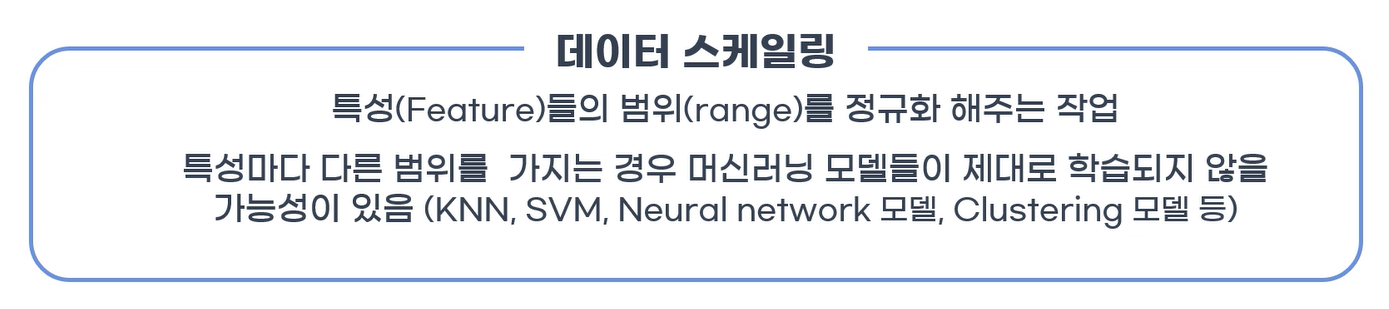
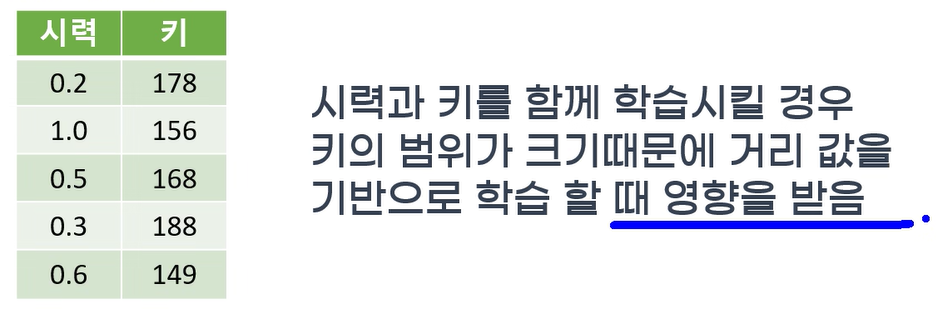
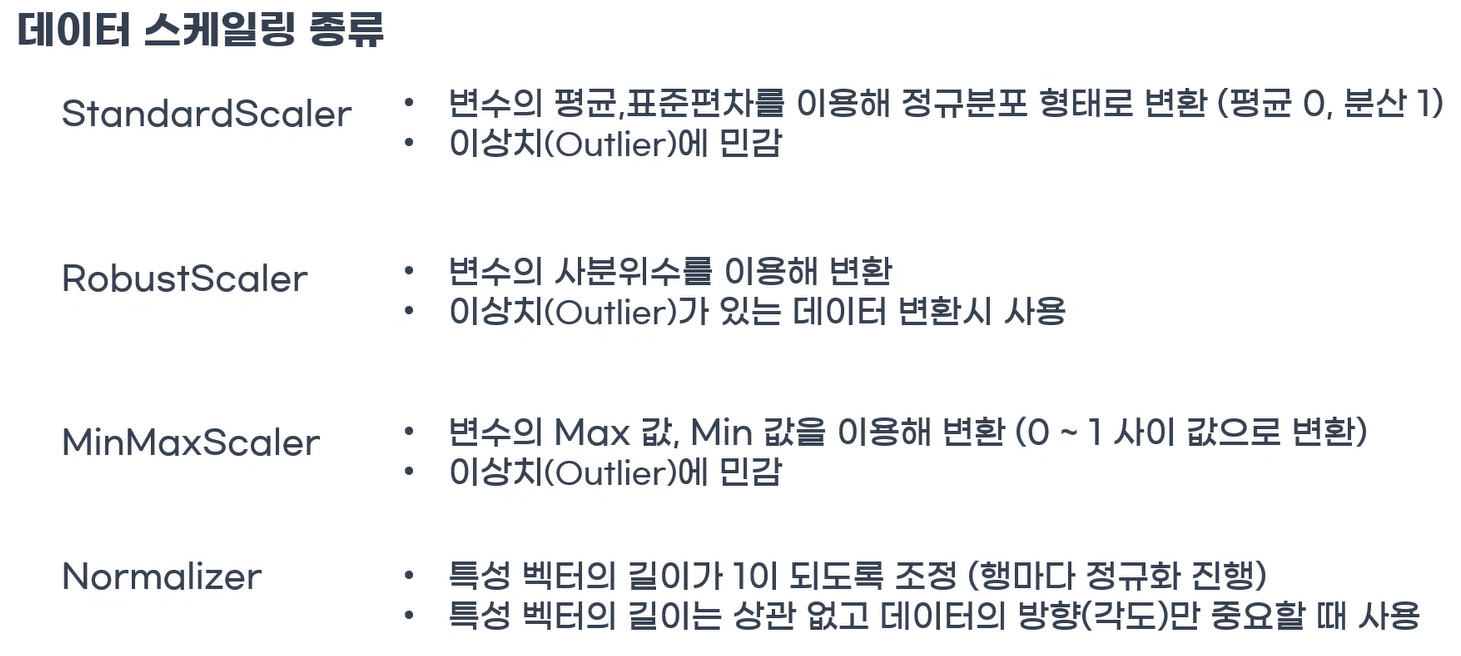

#### 데이터 스케일링 적용해보기

In [99]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer

In [100]:
# 도구(객체 생성)
scaler = StandardScaler()
X2 = scaler.fit_transform(X)  # numpy 배열로 결과물 반환
X2.min(), X2.max()

(-3.095652367643724, 41.58300833169649)

In [101]:
X2

array([[-1.73267445,  0.56697318, -0.37011481, ...,  1.04347348,
        -0.9023889 , -0.27945846],
       [-1.73264778, -0.29295518, -0.37011481, ...,  1.04347348,
        -0.9023889 , -0.27945846],
       [-1.7326211 ,  0.10393483, -0.33803645, ...,  1.04347348,
        -0.9023889 , -0.27945846],
       ...,
       [ 1.73166963,  0.17008317, -0.85530007, ..., -0.95833772,
        -0.9023889 ,  3.57834937],
       [ 1.7316963 ,  0.69926985, -0.85530007, ..., -0.95833772,
        -0.9023889 ,  3.57834937],
       [ 1.73172298, -1.28518021, -0.85530007, ..., -0.95833772,
        -0.9023889 ,  3.57834937]])

In [102]:
# 훈련, 테드스 분리 도구: train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X2,y, train_size=0.7, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(90640, 28) (38847, 28) (90640,) (38847,)


### 머신러닝 모델링
- 모델을 생성, 학습하는 일련의 과정: 모델링

In [133]:
# RandomForest, SVM(Support Vector Machine)
# test 데이터 평가 - 정확도
# 모델 일반적인 성능은? cross_val_score 평균값
# 뭐가 더 나은 모델인가?
ranFor = RandomForestClassifier(n_estimators=200, max_depth=5)
ranFor.fit(X_train, y_train)
pred = ranFor.predict(X_test)
print(accuracy_score(pred, y_test))

0.9194789816459443


In [105]:
from sklearn.svm import LinearSVC

In [106]:
svmLinear = LinearSVC(C=50, loss='squared_hinge')
svmLinear.fit(X_train, y_train)
pred = svmLinear.predict(X_test)
print(accuracy_score(pred, y_test))

0.8760007207763791


In [124]:
svmLinear2 = LinearSVC(C=5, loss='squared_hinge')
svmLinear2.fit(X_train, y_train)
pred = svmLinear2.predict(X_test)
print(accuracy_score(pred, y_test))

0.8760007207763791


In [128]:
svmLinear2 = LinearSVC(C=0.001, loss='squared_hinge')
svmLinear2.fit(X_train, y_train)
pred = svmLinear2.predict(X_test)
print(accuracy_score(pred, y_test))

0.8761809148711612


- SVM 시간 오래 걸림 -> 대안 : LinearSVC
- C 값이 커지면 과대적합을 약하게 제어(반비례)
- C 값이 작아지면 과적합을 크게 제어(반비례)
#### C값이 변경되어도 검증 성능이 큰 변화 없음
- 데이터에 크게 민감하지 않은 상황임
- 데이터 스케일링을 통해서 큰 변동이 없게(민감하지 않게) 처리해서 그 영향이 있을 수 있음

In [109]:
print('RandomForest',cross_val_score(ranFor, X2,y,cv=3))
print('svmLinear',cross_val_score(svmLinear, X2,y,cv=3))

RandomForest [0.89514167 0.92509615 0.93542931]
svmLinear [0.84472812 0.87762384 0.88431954]


In [119]:
sum([0.89514167, 0.92509615, 0.93542931])/3, sum([0.84472812, 0.87762384, 0.88431954])/3

(0.91855571, 0.8688905)

- RandomForest 모델이 평균 정확도 0.9182로 svmLinear 모델의 평균 정확도 0.8689보다 성능이 우수
- 교차 검증 결과를 통해, 두 모델의 일반화 성능을 비교했을 때, RandomForest가 더 높은 성능을 보임

In [ ]:
# 앙상브 유형의 모델들은 여러개 모델이 결합되어 최종 예측을 진행
#->  학습 시간이, 검증 시간이 오래 걸림
# 장점 : 성능 최대한으로 클어올릴 수있음 

-----

#### GridSearchCV : 최적의 하이퍼파라미터 조합을 확인해보자!

In [135]:
print(ranFor.score(X_train,y_train))
print(ranFor.score(X_test,y_test))

0.9210282436010592
0.9194789816459443


- train r규칙 복잡한 상황
- 일반화 추구
- train의 성능이 조금은 떨어져도, test와 비슷한 오차범위가 줄어드는 형태로 모델을 생성해내는게 좋다

In [138]:
from sklearn.model_selection import GridSearchCV

In [142]:
#1. 파라미터 경우의 수 정의
param_grid = {'n_estimators':[100,150,200], 'max_depth':[3,6,9,12]}
#2. 검증하고 싶은 모델 객체 정의
model = RandomForestClassifier(random_state=42)
#3. 모델과 파라미터를 연결
grid_rf = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, verbose=1)   # n_jobs=-1 : 사용가능한 컴퓨터 코어 다 써라
# verbose: 수행하는 내용 출력 여부 결정
#4. 그리드서치를 실행(학습): fit
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [100, 150, 200]},
             scoring='accuracy', verbose=1)

- 5 folds : 5번 교차검증 / cv=로 조절 가능

In [145]:
# 최적의 조합 확인하기
print('최고 평균 정확도:', grid_rf.best_score_)
print('최고 하이퍼파라미터 조합:', grid_rf.best_params_)

최고 평균 정확도: 0.9571601941747572
최고 하이퍼파라미터 조합: {'max_depth': 12, 'n_estimators': 150}


In [147]:
# best 모델 정의
best_model = RandomForestClassifier(max_depth=12, n_estimators=150, random_state=42)
best_model.fit(X_train, y_train)

# 성능 확인
print(best_model.score(X_train,y_train))
print(best_model.score(X_test,y_test))
print(round(best_model.score(X_train,y_train)-best_model.score(X_test,y_test),4))

0.9656884377758164
0.958606842227199
0.0071


#### 일반화 : train 성능은 조금 떨어지더라도, test성능이 최대가 되는 지점을(구간을 찾는 것)

- 트리 모델 기반해서 만들어진 모델: 특성의 중요도를 확인해보자

In [152]:
best_model.feature_importances_

array([0.0141287 , 0.01355776, 0.01510499, 0.00320748, 0.00463172,
       0.00908684, 0.03782343, 0.01755032, 0.17290588, 0.00799052,
       0.02445439, 0.03925596, 0.03275217, 0.02006893, 0.00614547,
       0.01830342, 0.15269807, 0.06157955, 0.0210302 , 0.00111158,
       0.00088516, 0.02773349, 0.02922363, 0.07363359, 0.06824598,
       0.08492436, 0.04064167, 0.00132475])

- 28개 중요도값, 값이 클수록 중요

In [169]:
rf_fi = pd.Series(best_model.feature_importances_, index=X.columns)
rf_fi.sort_values(ascending=False).head()

Online Boarding            0.172906
In-flight Wifi Service     0.152698
Class_Business             0.084924
Type of Travel_Business    0.073634
Type of Travel_Personal    0.068246
dtype: float64

<Axes: >

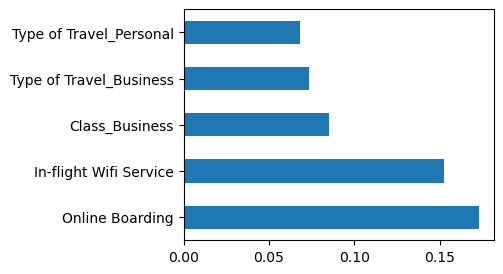

In [181]:
plt.figure(figsize=(4,3))
rf_fi.sort_values(ascending=False).head().plot.barh()